In [6]:
import numpy as np
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
#from shapely.geometry import Polygon, Point
from numpy import random
import time
import pandas as pd

In [7]:
# 석관동
입지후보지 = pd.read_csv('입지선정후보군_좌표추가.csv', encoding='EUC-KR')
입지후보지 = 입지후보지[입지후보지['행정동'] == '석관동']
print(입지후보지.shape)
입지후보지.head(2)

(9, 6)


,분류,시설명,x좌표,y좌표,법정동,행정동
0,간이운동장,돌 뫼,127.052763,37.605125,석관동,석관동
5,간이운동장,샛 별,127.064140,37.614111,석관동,석관동


In [8]:
# 입지후보지['행정동'].unique()

In [9]:
# 버스['행정동'].unique()

In [10]:
버스 = pd.read_csv('서울시_버스정류장_행정동추가.csv')
버스 = 버스[버스['행정동'].isin(['석관동','월곡2동','회기동','이문1동','이문2동','묵2동','공릉1동',\
                                 '월계3동','월계1동','장위1동','장위2동','장위3동'])]
print(버스.shape)
버스.head(2)

(197, 7)


,정류소명,X좌표,Y좌표,정류버스수,행정동,행정동_경도,행정동_위도
120,석계역,127.067231,37.615065,25,석관동,127.061437,37.612982
149,한진한화그랑빌아파트,127.069914,37.618255,23,월계3동,127.069259,37.621015


In [11]:
지하철 = pd.read_csv('서울시_지하철역_행정동추가.csv', encoding='EUC-KR', index_col=0)
지하철 = 지하철[지하철['행정동'].isin(['석관동','월곡2동','회기동','이문1동','이문2동','묵2동','공릉1동',\
                                       '월계3동','월계1동','장위1동','장위2동','장위3동'])]
print(지하철.shape)
지하철.head(2)

(12, 14)


,전철역코드,전철역명,전철명명(영문),호선,외부코드,검색키워드,주소,위도,경도,환승역,H/B,행정동,행정동_경도,행정동_위도
164,2642,월곡역,Wolgok,6호선,641,월곡역 6호선,서울 성북구 월곡로 지하 107,37.601421,127.041185,0,H,월곡2동,127.047886,37.605792
165,2643,상월곡역,Sangwolgok,6호선,642,상월곡역 6호선,서울 성북구 화랑로 지하 157,37.606264,127.048327,0,H,월곡2동,127.047886,37.605792


In [12]:
주차장 = pd.read_csv('서울시_주차장_행정동추가.csv', encoding='EUC-KR', index_col=0).drop('Unnamed: 0.1', axis=1)
주차장 = 주차장[주차장['행정동'].isin(['석관동','월곡2동','회기동','이문1동','이문2동','묵2동','공릉1동',\
                                       '월계3동','월계1동','장위1동','장위2동','장위3동'])]
print(주차장.shape)
주차장.head(2)

(27, 9)


,주차장id,주차장이름,주소,경도,위도,H/B,행정동,행정동_경도,행정동_위도
331,26535897,회기동공영주차장,서울 동대문구 회기동 1-1,127.055785,37.591502,H,회기동,127.055372,37.590789
332,2085355453,회기동공영주차장 전기차충전소,서울 동대문구 이문동 340-1,127.055959,37.591342,H,회기동,127.055372,37.590789


In [13]:
주택 = pd.read_csv('서울시주택_행정동추가.csv', encoding='EUC-KR', index_col=0).drop('Unnamed: 0.1', axis=1)
주택 = 주택[주택['행정동'].isin(['석관동','월곡2동','회기동','이문1동','이문2동','묵2동','공릉1동',\
                                 '월계3동','월계1동','장위1동','장위2동','장위3동'])]
print(주택.shape)
주택.head(2)

(18, 14)


,구명,단지명,주택유형,세대수,입주개시일,주소,우편번호,전화번호,경도,위도,H/B,행정동,행정동_경도,행정동_위도
157,노원구,공릉1,영구임대,1395,1994-12-08,동일로 1127 (공릉동 공릉1단지아파트),1851,NaN,37.629590,127.069855,H,공릉1동,127.073821,37.624836
158,노원구,월계사슴1,영구임대,1372,1995-06-29,월계로 372 (월계동 월계사슴1단지아파트),1905,NaN,37.629247,127.059664,H,월계3동,127.069259,37.621015


In [14]:
X = list(버스['X좌표']) + list(지하철['경도']) + list(주차장['경도']) + list(주택['위도'])     # 주택 위도 경도 이름 바뀜
X[:2]

[127.06723070700001, 127.0699139994]

In [15]:
Y = list(버스['Y좌표']) + list(지하철['위도']) + list(주차장['위도']) + list(주택['경도'])
Y[:2]

[37.6150652627, 37.6182551734]

In [16]:
points = np.array([list(i) for i in zip(X, Y)])
print(points.shape)
points

(254, 2)


array([[127.06723071,  37.61506526],
       [127.069914  ,  37.61825517],
       [127.06700402,  37.61519435],
       [127.06846538,  37.60138416],
       [127.06504568,  37.61481352],
       [127.07446082,  37.61714368],
       [127.0616454 ,  37.63190225],
       [127.0562794 ,  37.61050124],
       [127.05794369,  37.59307434],
       [127.0616826 ,  37.61341583],
       [127.05226554,  37.61886384],
       [127.05912443,  37.62819148],
       [127.05138516,  37.61815713],
       [127.04972929,  37.61699338],
       [127.07795706,  37.60894677],
       [127.07830619,  37.60714763],
       [127.05735118,  37.61603976],
       [127.06814105,  37.62388282],
       [127.06922721,  37.62148594],
       [127.06989109,  37.61941184],
       [127.06576271,  37.61441154],
       [127.0596615 ,  37.5956045 ],
       [127.05665611,  37.59119545],
       [127.05741101,  37.62851471],
       [127.04578914,  37.61386024],
       [127.04304133,  37.61390581],
       [127.07155554,  37.62832177],
 

In [131]:
수요지점 = pd.DataFrame(points, columns=['경도','위도'])
수요지점.to_csv('석관동_수요지점.csv', index=False)

In [117]:
# # 보유하고 있는 좌표(points)의 모양에 맞는 도형 생성
# # 해당 도형 안에 포함되는 random한 좌표 생성 (임의의 노인놀이터 위치 좌표)
# def generate_candidate_sites(points, M=100):
#     '''
#     Generate M candidate sites with the convex hull of a point set
#     Input:
#         points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
#         M: 생성할 random 좌표 수 (임의의 노인놀이터 수)
#     Return:
#         sites: a Numpy array with shape of (M,2)
#     '''
#     hull = ConvexHull(points)                                   # points 좌표들의 외곽선 생성
#     polygon_points = points[hull.vertices]                      # 외곽선을 구성하는 직선 간 점(좌표) 반환
#     poly = Polygon(polygon_points)                              # 외곽선 모양의 도형 생성
#     min_x, min_y, max_x, max_y = poly.bounds                    # 도형의 x축과 y축 좌표 최소,최대
#     sites = []
#     while len(sites) < M:
#         random_point = Point([random.uniform(min_x, max_x),     # x축 범위 내 random한 값
#                               random.uniform(min_y, max_y)])    # y축 범위 내 random한 값
#         if (random_point.within(poly)):                         # random한 좌표가 도형 안에 있다면 sites에 추가
#             sites.append(random_point)
#     return np.array([(p.x,p.y) for p in sites])

In [118]:
def mclp(points,K,radius):
    """
    Solve maximum covering location problem
    Input:
        points: 버스정류장, 지하철역 위치 좌표 등 (기타 인근에 있으면 좋은 시설 좌표)
        K: 배치할 노인놀이터의 수
        radius: 반경 (노인들이 이동하기 적합한 거리)
        M: generate_candidate_sites 함수에서 생성할 random 좌표 수 (임의의 노인놀이터 수)
        the ConvexHull wrapped by the polygon
    Return:
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        f: the optimal value of the objective function
    """
    print('  Number of points %g' % points.shape[0])
    print('  K %g' % K)
    print('  Radius %g' % radius)

    start = time.time()
    sites = np.array([list(i) for i in zip(입지후보지['x좌표'], 입지후보지['y좌표'])])
    J = sites.shape[0]                                         # 임의의 노인놀이터 좌표 개수
    I = points.shape[0]                                        # 버스정류장, 지하철역 위치 좌표 개수
    D = distance_matrix(points,sites)                          # 노인놀이터와 버스/지하철역 좌표 간 거리 계산
    mask1 = D<=radius
    D[mask1]=1                                                 # 버스/지하철역 좌표별로 노인놀이터의 반경 내 속하면 1, 아니면 0
    D[~mask1]=0
    # Build model
    m = Model()
    # Add variables
    x = {}
    y = {}
    for i in range(I):                                        # 버스/지하철역 좌표 개수만큼 반복
        y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)     # 모델에 결정 변수 추가 (변수 유형은 BINARY. 위치별 인수, 변수 이름 y+숫자)
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)     # 노인놀이터 좌표 개수만큼 반복하여 변수 추가

    m.update()
    # Add constraints
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i] for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Output -----')
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
                solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

In [142]:
opts_sites, mobjVal = mclp(points, 3, 0.005)
opts_sites

  Number of points 254
  K 3
  Radius 0.005
----- Output -----
  Running time : 0.02290177345275879 seconds
  Optimal coverage points: 35


array([[127.052763,  37.605125],
       [127.06414 ,  37.614111],
       [127.054559,  37.608453]])

In [143]:
최적입지 = pd.DataFrame(opts_sites, columns=['경도','위도'])
최적입지.to_csv('석관동_최적입지.csv', index=False)

In [137]:
def plot_input(points):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

In [138]:
def plot_result(points,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Numpy array in shape of [K,2]
        radius: the radius of circle
    '''
    from matplotlib import pyplot as plt
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

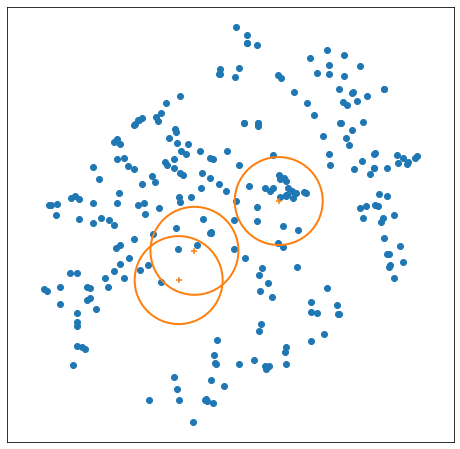

In [144]:
plot_result(points, opts_sites, 0.005)